In [13]:
import os
import cv2
import numpy as np
from tqdm import tqdm # progress bar

REBUILD_DATA = False

In [11]:
class PetClassification:
    IMG_SIZE = 50
    CATS = "../data/PetImages/Cat"
    DOGS = "../data/PetImages/Dog"
    LABELS = {CATS:0, DOGS:1}
    training_data = []
    catcount = 0
    dogcount = 0
    
    # import training data into NP array - only needs to be run once
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                    if (label == self.CATS):
                        self.catcount += 1
                    elif (label == self.DOGS):
                        self.dogcount += 1
                except Exception as e:
                    # in case corrupted data
                    pass
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print("Cats: ", self.catcount, " Dogs: ", self.dogcount)        

In [12]:
if REBUILD_DATA:
    pc = PetClassification()
    pc.make_training_data()

  0%|          | 56/12501 [00:00<00:22, 550.62it/s]

../data/PetImages/Cat


  0%|          | 49/12501 [00:00<00:25, 479.97it/s]

../data/PetImages/Dog


100%|██████████| 12501/12501 [00:21<00:00, 587.08it/s]


Cats:  12476  Dogs:  12470


In [15]:
training_data = np.load("training_data.npy", allow_pickle=True)

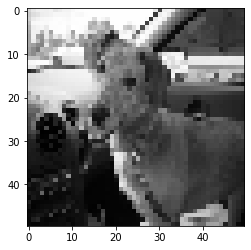

In [26]:
import matplotlib.pyplot as plt

plt.imshow(training_data[2][0], cmap="gray")
plt.show()

In [40]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        x = torch.randn(50, 50).view(-1, 1, 50, 50)
        self._to_linear = None
        self.convs(x)
        # flatten in keras
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)
        
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        
        print(x[0].shape)
        if (self._to_linear is None):
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    

In [41]:
net = Net()

torch.Size([128, 2, 2])
